In [ ]:
# Mount Drive (recommended so outputs persist)
from google.colab import drive
drive.mount('/content/drive')

# Install dependencies
!pip install --quiet kaggle opencv-python-headless tqdm numpy


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p /root/.kaggle
!cp "/content/drive/MyDrive/kaggle/kaggle.json" /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
# target folder
!pip install kagglehub --quiet


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("manideep1108/tusimple")

print("Path to dataset files:", path)


100%|██████████| 21.6G/21.6G [03:52<00:00, 100MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/manideep1108/tusimple/versions/5


In [ ]:
# install libs
!pip install --quiet kagglehub opencv-python-headless torch torchvision torchaudio --upgrade
!pip install --quiet matplotlib tqdm albumentations gradio

In [ ]:
# RESET (optional): clears previous tmp folders if they exist
!rm -rf /content/tmp_lane
!mkdir -p /content/tmp_lane

# Deps
!pip install --quiet kagglehub opencv-python-headless torch torchvision torchaudio tqdm

import os, random, numpy as np, torch
random.seed(42); np.random.seed(42); torch.manual_seed(42)

# Paths
RAW_ROOT   = "/root/.cache/kagglehub/datasets/manideep1108/tusimple/versions/5"  # already downloaded via kagglehub
WORK_ROOT  = "/content/tmp_lane"
IMG_DIR    = f"{WORK_ROOT}/images"
MSK_DIR    = f"{WORK_ROOT}/masks"
SPLIT_DIR  = f"{WORK_ROOT}/split"
MODEL_OUT  = f"{WORK_ROOT}/unet_best.pt"   # final model (we'll download this)
DEMO_VID   = f"{WORK_ROOT}/demo_pred.mp4"  # optional demo

for d in [IMG_DIR, MSK_DIR, SPLIT_DIR]:
    os.makedirs(d, exist_ok=True)

print("RAW_ROOT:", RAW_ROOT)
print("IMG_DIR:", IMG_DIR)
print("MSK_DIR:", MSK_DIR)
print("SPLIT_DIR:", SPLIT_DIR)
print("MODEL_OUT:", MODEL_OUT)


RAW_ROOT: /root/.cache/kagglehub/datasets/manideep1108/tusimple/versions/5
IMG_DIR: /content/tmp_lane/images
MSK_DIR: /content/tmp_lane/masks
SPLIT_DIR: /content/tmp_lane/split
MODEL_OUT: /content/tmp_lane/unet_best.pt


In [ ]:
# ==== CLEAN START ====
!pip -q install kagglehub opencv-python-headless torch torchvision torchaudio tqdm

import os, shutil
RAW_ROOT = "/root/.cache/kagglehub/datasets/manideep1108/tusimple/versions/5"  # kagglehub path you printed
TMP_ROOT = "/content/tmp_lane"
IMG_DIR  = f"{TMP_ROOT}/images"
MSK_DIR  = f"{TMP_ROOT}/masks"
SPLIT    = f"{TMP_ROOT}/split"
MODEL_OUT = "/content/unet_best.pt"

# wipe old tmp
for d in [IMG_DIR, MSK_DIR, SPLIT]:
    if os.path.exists(d): shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

print("RAW_ROOT:", RAW_ROOT)
print("IMG_DIR:", IMG_DIR)
print("MSK_DIR:", MSK_DIR)
print("SPLIT:", SPLIT)
print("MODEL_OUT:", MODEL_OUT)


RAW_ROOT: /root/.cache/kagglehub/datasets/manideep1108/tusimple/versions/5
IMG_DIR: /content/tmp_lane/images
MSK_DIR: /content/tmp_lane/masks
SPLIT: /content/tmp_lane/split
MODEL_OUT: /content/unet_best.pt


In [ ]:
import os, glob, json, cv2, numpy as np
from tqdm import tqdm

RAW_ROOT = "/root/.cache/kagglehub/datasets/manideep1108/tusimple/versions/5"
IMG_DIR  = "/content/tmp_lane/images"
MSK_DIR  = "/content/tmp_lane/masks"
RESIZE   = (512, 256)  # (W,H)

os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(MSK_DIR, exist_ok=True)

# --- find label files (prefer train labels; skip test) ---
all_labels = sorted(glob.glob(os.path.join(RAW_ROOT, "**", "*label*.json"), recursive=True))
train_labels = [p for p in all_labels if "test" not in os.path.basename(p).lower()]
if not train_labels:
    # fallback: any jsons that look like train
    all_jsons = sorted(glob.glob(os.path.join(RAW_ROOT, "**", "*.json"), recursive=True))
    train_labels = [p for p in all_jsons if ("label" in os.path.basename(p).lower() and "test" not in os.path.basename(p).lower())]
print("Found label files:", [os.path.basename(x) for x in train_labels])

# --- helper to stream entries from json/jsonlines ---
def stream_entries(path, limit=None):
    n = 0
    with open(path, 'r') as f:
        first = f.read(1); f.seek(0)
        if first == '[':
            data = json.load(f)
            for e in data:
                yield e
                n += 1
                if limit and n >= limit: break
        else:
            for line in f:
                line = line.strip()
                if not line: continue
                try:
                    e = json.loads(line)
                    yield e
                    n += 1
                    if limit and n >= limit: break
                except:
                    pass

# --- choose the correct DATA_BASE by checking where raw_file exists ---
def detect_base(raw_root, labels):
    # candidates: any directory that contains "clips" and its parent chain
    clip_dirs = sorted(glob.glob(os.path.join(raw_root, "**", "clips"), recursive=True), key=len)
    candidates = set()
    for c in clip_dirs:
        d = os.path.dirname(c)              # .../train_set (or root with clips)
        candidates.add(d)
        candidates.add(os.path.dirname(d))  # parent as fallback
    candidates = [c for c in candidates if os.path.isdir(c)]
    if not candidates:
        return None

    # collect a few sample raw_file names from first label
    sample_label = labels[0]
    samples = []
    for e in stream_entries(sample_label, limit=50):
        rf = e.get('raw_file') or e.get('raw_files') or e.get('raw')
        if rf: samples.append(rf.lstrip("/"))
    samples = samples[:20]

    best_base = None
    best_hits = -1
    for base in candidates:
        hits = 0
        for rf in samples:
            if os.path.exists(os.path.join(base, rf)):
                hits += 1
        if hits > best_hits:
            best_hits = hits
            best_base = base
    return best_base, best_hits

DATA_BASE, hits = detect_base(RAW_ROOT, train_labels)
print("Detected DATA_BASE:", DATA_BASE, "| sample hits:", hits)
assert DATA_BASE and hits > 0, "Failed to locate base with images. Check RAW_ROOT or dataset integrity."

# --- preprocess to images + masks (unique names) ---
count = 0
for jf in train_labels:
    entries = stream_entries(jf)
    file_count = 0
    for e in tqdm(entries, desc=os.path.basename(jf)):
        rf = e.get('raw_file') or e.get('raw_files') or e.get('raw')
        lanes = e.get('lanes', [])
        h_samples = e.get('h_samples', [])
        if not (rf and lanes and h_samples):
            continue

        img_path = os.path.join(DATA_BASE, rf.lstrip("/"))
        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        h, w = img.shape[:2]
        mask = np.zeros((h, w), dtype=np.uint8)

        # draw lane polylines
        for xs in lanes:
            pts = []
            for x, y in zip(xs, h_samples):
                try:
                    xi = int(x)
                except:
                    continue
                if 0 < xi < w:
                    pts.append((xi, int(y)))
            if len(pts) >= 2:
                cv2.polylines(mask, [np.array(pts, np.int32)], False, 255, 12)

        # light dilate to connect gaps
        mask = cv2.dilate(mask, np.ones((5,5), np.uint8), iterations=1)

        # resize for speed/VRAM
        img  = cv2.resize(img,  RESIZE)
        mask = cv2.resize(mask, RESIZE, interpolation=cv2.INTER_NEAREST)

        # unique filename from relative path
        fname = rf.replace("/", "_")
        img_out = os.path.join(IMG_DIR, fname)                                 # jpg
        msk_out = os.path.join(MSK_DIR, os.path.splitext(fname)[0] + ".png")   # png

        cv2.imwrite(img_out, img,  [cv2.IMWRITE_JPEG_QUALITY, 85])
        cv2.imwrite(msk_out, mask, [cv2.IMWRITE_PNG_COMPRESSION, 1])
        count += 1
        file_count += 1
    print(f"{os.path.basename(jf)} -> {file_count} pairs")

print("\nProcessed pairs:", count)
print("Images ->", IMG_DIR, "count:", len(os.listdir(IMG_DIR)))
print("Masks  ->", MSK_DIR, "count:", len(os.listdir(MSK_DIR)))
assert len(os.listdir(IMG_DIR)) > 0, "0 pairs created. If this triggers, print DATA_BASE and sample rf to debug."


Found label files: ['label_data_0313.json', 'label_data_0531.json', 'label_data_0601.json']
Detected DATA_BASE: /root/.cache/kagglehub/datasets/manideep1108/tusimple/versions/5/TUSimple/train_set | sample hits: 20


label_data_0313.json: 2858it [00:35, 79.60it/s]


label_data_0313.json -> 2858 pairs


label_data_0531.json: 358it [00:04, 80.33it/s]


label_data_0531.json -> 358 pairs


label_data_0601.json: 410it [00:03, 109.47it/s]

label_data_0601.json -> 410 pairs

Processed pairs: 3626
Images -> /content/tmp_lane/images count: 3626
Masks  -> /content/tmp_lane/masks count: 3626


In [ ]:
import os, shutil, random

IMG_DIR = "/content/tmp_lane/images"
MSK_DIR = "/content/tmp_lane/masks"
SPLIT   = "/content/tmp_lane/split"

# reset split dirs
if os.path.exists(SPLIT): shutil.rmtree(SPLIT)
train_img = f"{SPLIT}/train/images"; train_msk = f"{SPLIT}/train/masks"
val_img   = f"{SPLIT}/val/images";   val_msk   = f"{SPLIT}/val/masks"
for d in [train_img, train_msk, val_img, val_msk]:
    os.makedirs(d, exist_ok=True)

# pair images with masks (masks saved as .png)
files = []
for f in sorted(os.listdir(IMG_DIR)):
    b,_ = os.path.splitext(f)
    m = b + ".png"
    if os.path.exists(os.path.join(MSK_DIR, m)):
        files.append((f, m))

random.seed(42); random.shuffle(files)
n = len(files); nval = max(1, int(0.1*n))
val_pairs   = files[:nval]
train_pairs = files[nval:]

for f, m in train_pairs:
    shutil.copy(os.path.join(IMG_DIR, f), os.path.join(train_img, f))
    shutil.copy(os.path.join(MSK_DIR, m), os.path.join(train_msk, m))
for f, m in val_pairs:
    shutil.copy(os.path.join(IMG_DIR, f), os.path.join(val_img, f))
    shutil.copy(os.path.join(MSK_DIR, m), os.path.join(val_msk, m))

print("Train images:", len(os.listdir(train_img)), " Val images:", len(os.listdir(val_img)))


Train images: 3264  Val images: 362


In [ ]:
%%bash
cat > /content/train_lane_unet.py << 'PY'
#!/usr/bin/env python3
# train_lane_unet.py
# Tiny U-Net for lane segmentation (binary). Mixed-precision, saves best checkpoint.

import os
import argparse
import random
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torch.cuda.amp import autocast, GradScaler

# ------------- Utils -------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True   # speed

def count_files(d):
    return len(os.listdir(d)) if os.path.isdir(d) else 0

# ------------- Model -------------
class DoubleConv(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(i, o, 3, padding=1), nn.ReLU(True),
            nn.Conv2d(o, o, 3, padding=1), nn.ReLU(True),
        )
    def forward(self, x): return self.net(x)

class TinyUNet(nn.Module):
    def __init__(self, base=32, in_ch=3, out_ch=1):
        super().__init__()
        self.e1 = DoubleConv(in_ch, base)
        self.p  = nn.MaxPool2d(2)
        self.e2 = DoubleConv(base, base*2)
        self.e3 = DoubleConv(base*2, base*4)
        self.u2 = nn.ConvTranspose2d(base*4, base*2, 2, 2)
        self.d2 = DoubleConv(base*4, base*2)
        self.u1 = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.d1 = DoubleConv(base*2, base)
        self.out= nn.Conv2d(base, out_ch, 1)
    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(self.p(e1))
        e3 = self.e3(self.p(e2))
        d2 = self.u2(e3)
        d2 = self.d2(torch.cat([d2, e2], 1))
        d1 = self.u1(d2)
        d1 = self.d1(torch.cat([d1, e1], 1))
        return self.out(d1)

# ------------- Dataset -------------
class LaneDataset(Dataset):
    def __init__(self, img_dir, msk_dir, size=(512,256), augment=True):
        self.img_dir, self.msk_dir = img_dir, msk_dir
        self.size = size
        self.augment = augment
        # images can be .jpg/.png; masks must be .png (binary)
        self.imgs = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir)])
        self.msks = []
        for ip in self.imgs:
            b = os.path.splitext(os.path.basename(ip))[0]
            mp = os.path.join(msk_dir, b + ".png")
            if not os.path.exists(mp):
                raise FileNotFoundError(f"Mask not found for {ip}: {mp}")
            self.msks.append(mp)
        assert len(self.imgs) == len(self.msks) and len(self.imgs) > 0, "Empty dataset or mismatch."

    def __len__(self): return len(self.imgs)

    def __getitem__(self, i):
        img = cv2.imread(self.imgs[i])[:,:,::-1]
        msk = cv2.imread(self.msks[i], cv2.IMREAD_GRAYSCALE)
        # resize
        img = cv2.resize(img, self.size)  # (W,H)
        msk = cv2.resize(msk, self.size, interpolation=cv2.INTER_NEAREST)
        # normalize
        img = img.astype(np.float32) / 255.0
        msk = (msk > 127).astype(np.float32)
        # to tensors
        img_t = torch.from_numpy(img.transpose(2,0,1)).float()
        msk_t = torch.from_numpy(msk)[None].float()
        # light aug
        if self.augment and np.random.rand() < 0.5:
            img_t = TF.hflip(img_t)
            msk_t = TF.hflip(msk_t)
        return img_t, msk_t

# ------------- Training -------------
def validate(model, loader, device, crit):
    model.eval()
    loss_sum = 0.0
    with torch.no_grad(), autocast(enabled=True):
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            p = model(x)
            loss_sum += crit(p, y).item()
    return loss_sum / max(1, len(loader))

def train(cfg):
    set_seed(cfg.seed)
    device = torch.device('cuda' if torch.cuda.is_available() and not cfg.cpu else 'cpu')

    # data
    train_ds = LaneDataset(os.path.join(cfg.train_dir, "images"),
                           os.path.join(cfg.train_dir, "masks"),
                           size=(cfg.width, cfg.height), augment=True)
    val_ds   = LaneDataset(os.path.join(cfg.val_dir, "images"),
                           os.path.join(cfg.val_dir, "masks"),
                           size=(cfg.width, cfg.height), augment=False)

    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                              num_workers=cfg.workers, pin_memory=True, persistent_workers=False)
    val_loader   = DataLoader(val_ds,   batch_size=max(1, cfg.batch_size//2), shuffle=False,
                              num_workers=max(1, cfg.workers//2), pin_memory=True, persistent_workers=False)

    # model/opt
    model = TinyUNet(base=cfg.base).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    crit = nn.BCEWithLogitsLoss()
    scaler = GradScaler(enabled=not cfg.no_amp)

    os.makedirs(os.path.dirname(cfg.out), exist_ok=True) if os.path.dirname(cfg.out) else None

    best = float('inf')
    for ep in range(1, cfg.epochs+1):
        model.train()
        run = 0.0
        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with autocast(enabled=not cfg.no_amp):
                p = model(x)
                loss = crit(p, y)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            run += loss.item()
        tr_loss = run / max(1, len(train_loader))
        va_loss = validate(model, val_loader, device, crit)

        print(f"Epoch {ep}/{cfg.epochs}  train:{tr_loss:.4f}  val:{va_loss:.4f}")

        if va_loss < best:
            best = va_loss
            torch.save(model.state_dict(), cfg.out)
            print(f"✓ Saved best -> {cfg.out}")

    print("Done. Best val loss:", best)

def parse_args():
    p = argparse.ArgumentParser(description="Train Tiny U-Net for Lane Segmentation")
    p.add_argument('--train_dir', type=str, default='/content/tmp_lane/split/train',
                   help='train directory with subfolders images/ and masks/')
    p.add_argument('--val_dir', type=str, default='/content/tmp_lane/split/val',
                   help='val directory with subfolders images/ and masks/')
    p.add_argument('--out', type=str, default='/content/unet_best.pt', help='path to save best model')
    p.add_argument('--width', type=int, default=512, help='resize width')
    p.add_argument('--height', type=int, default=256, help='resize height')
    p.add_argument('--base', type=int, default=32, help='U-Net base channels (reduce to 16 if low VRAM)')
    p.add_argument('--batch_size', type=int, default=6, help='train batch size (try 4 if OOM)')
    p.add_argument('--workers', type=int, default=2, help='DataLoader workers')
    p.add_argument('--epochs', type=int, default=6, help='number of training epochs')
    p.add_argument('--lr', type=float, default=1e-3, help='learning rate')
    p.add_argument('--seed', type=int, default=42, help='random seed')
    p.add_argument('--cpu', action='store_true', help='force CPU')
    p.add_argument('--no_amp', action='store_true', help='disable mixed precision')
    return p.parse_args()

if __name__ == "__main__":
    cfg = parse_args()
    # quick sanity checks
    assert os.path.isdir(os.path.join(cfg.train_dir, "images")), f"Missing {cfg.train_dir}/images"
    assert os.path.isdir(os.path.join(cfg.train_dir, "masks")),  f"Missing {cfg.train_dir}/masks"
    assert os.path.isdir(os.path.join(cfg.val_dir, "images")),   f"Missing {cfg.val_dir}/images"
    assert os.path.isdir(os.path.join(cfg.val_dir, "masks")),    f"Missing {cfg.val_dir}/masks"
    print("Train images:", count_files(os.path.join(cfg.train_dir, "images")),
          "| Val images:", count_files(os.path.join(cfg.val_dir, "images")))
    train(cfg)
PY


In [ ]:
!python /content/train_lane_unet.py \
  --train_dir /content/tmp_lane/split/train \
  --val_dir   /content/tmp_lane/split/val \
  --out       /content/unet_best.pt \
  --width 512 --height 256 \
  --batch_size 6 --workers 2 --epochs 6

Train images: 3264 | Val images: 362
/content/train_lane_unet.py:127: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=not cfg.no_amp)
/content/train_lane_unet.py:139: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=not cfg.no_amp):
/content/train_lane_unet.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=True):
Epoch 1/6  train:0.1636  val:0.1190
✓ Saved best -> /content/unet_best.pt
Epoch 2/6  train:0.1078  val:0.0966
✓ Saved best -> /content/unet_best.pt
Epoch 3/6  train:0.0907  val:0.0839
✓ Saved best -> /content/unet_best.pt
Epoch 4/6  train:0.0826  val:0.0788
✓ Saved best -> /content/unet_best.pt
Epoch 5/6  train:0.0788  val:0.0764
✓ Saved best -> /content/

In [ ]:
from google.colab import files
files.download("/content/unet_best.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch, cv2, os, glob, numpy as np, time
import torch.nn as nn

# --- tiny UNet (same as training) ---
class DoubleConv(nn.Module):
    def __init__(self,i,o):
        super().__init__()
        self.net=nn.Sequential(
            nn.Conv2d(i,o,3,padding=1), nn.ReLU(True),
            nn.Conv2d(o,o,3,padding=1), nn.ReLU(True)
        )
    def forward(self,x): return self.net(x)
class TinyUNet(nn.Module):
    def __init__(self, base=32):
        super().__init__()
        self.e1=DoubleConv(3,base); self.p=nn.MaxPool2d(2)
        self.e2=DoubleConv(base,base*2); self.e3=DoubleConv(base*2,base*4)
        self.u2=nn.ConvTranspose2d(base*4,base*2,2,2); self.d2=DoubleConv(base*4,base*2)
        self.u1=nn.ConvTranspose2d(base*2,base,2,2);   self.d1=DoubleConv(base*2,base)
        self.out=nn.Conv2d(base,1,1)
    def forward(self,x):
        e1=self.e1(x); e2=self.e2(self.p(e1)); e3=self.e3(self.p(e2))
        d2=self.u2(e3); d2=self.d2(torch.cat([d2,e2],1))
        d1=self.u1(d2); d1=self.d1(torch.cat([d1,e1],1))
        return self.out(d1)

# --- paths & load ---
VAL_IMG_DIR = "/content/tmp_lane/split/val/images"
VAL_MSK_DIR = "/content/tmp_lane/split/val/masks"
MODEL_PATH  = "/content/unet_best.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyUNet(base=32).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# --- helpers ---
def sigmoid(x): return 1/(1+np.exp(-x))
def read_pair(img_path):
    b = os.path.splitext(os.path.basename(img_path))[0]
    m = os.path.join(VAL_MSK_DIR, b+".png")
    img = cv2.imread(img_path)[:,:,::-1]           # RGB
    msk = cv2.imread(m, cv2.IMREAD_GRAYSCALE)
    return img, msk

def infer_mask(img):
    h,w = img.shape[:2]
    inp = cv2.resize(img,(512,256)).astype('float32')/255.0
    x = torch.from_numpy(inp.transpose(2,0,1))[None].to(device)
    with torch.no_grad():
        y = torch.sigmoid(model(x))[0,0].cpu().numpy()
    return cv2.resize((y*255).astype('uint8'), (w,h), interpolation=cv2.INTER_NEAREST)

def metrics_bin(pred, gt, thr=128):
    p = (pred>=thr).astype(np.uint8); g = (gt>=128).astype(np.uint8)
    tp = np.sum((p==1)&(g==1))
    fp = np.sum((p==1)&(g==0))
    fn = np.sum((p==0)&(g==1))
    tn = np.sum((p==0)&(g==0))
    iou = tp / (tp+fp+fn+1e-9)
    dice= (2*tp) / (2*tp+fp+fn+1e-9)
    prec= tp / (tp+fp+1e-9)
    rec = tp / (tp+fn+1e-9)
    return dict(iou=iou, dice=dice, precision=prec, recall=rec, tp=tp, fp=fp, fn=fn, tn=tn)

# --- evaluate ---
val_imgs = sorted(glob.glob(os.path.join(VAL_IMG_DIR, "*")))
assert val_imgs, "No val images found."

# threshold sweep to find best F1 (Dice)
ths = list(range(60, 201, 10))  # 0.24..0.8
agg = {t:{'tp':0,'fp':0,'fn':0} for t in ths}
per_image = []  # store per-image IoU at thr=128

t0=time.time(); n_timed=min(100,len(val_imgs))
for idx, ip in enumerate(val_imgs):
    img, gt = read_pair(ip)
    pred = infer_mask(img)

    # per-image metrics at 128
    m = metrics_bin(pred, gt, thr=128)
    per_image.append((ip, m['iou'], m['dice']))

    # aggregate over thresholds
    g = (gt>=128).astype(np.uint8)
    for t in ths:
        p = (pred>=t).astype(np.uint8)
        agg[t]['tp'] += int(((p==1)&(g==1)).sum())
        agg[t]['fp'] += int(((p==1)&(g==0)).sum())
        agg[t]['fn'] += int(((p==0)&(g==1)).sum())

    # timing for FPS
    if idx < n_timed: pass
t1=time.time()
fps = n_timed / max(1e-6, (t1-t0))

# aggregate results
def f1(tp,fp,fn): return (2*tp)/(2*tp+fp+fn+1e-9)
best_t, best_f1 = None, -1
for t in ths:
    F1 = f1(agg[t]['tp'], agg[t]['fp'], agg[t]['fn'])
    if F1>best_f1: best_f1, best_t = F1, t

mean_iou  = float(np.mean([x[1] for x in per_image]))
mean_dice = float(np.mean([x[2] for x in per_image]))

print(f"Validation @thr=128  mIoU={mean_iou:.4f}  Dice(F1)={mean_dice:.4f}")
print(f"Best threshold by global F1: {best_t}  (F1={best_f1:.4f})")
print(f"Approx inference speed: ~{fps:.1f} FPS on {device}")

# show 3 best & 3 worst IoU samples (filenames)
per_image.sort(key=lambda z: z[1])  # by IoU
worst3 = per_image[:3]
best3  = per_image[-3:]
print("\nWorst 3 IoU:")
for p,iou,d in worst3: print(f"{os.path.basename(p)}  IoU={iou:.3f}")
print("\nBest 3 IoU:")
for p,iou,d in best3: print(f"{os.path.basename(p)}  IoU={iou:.3f}")


Validation @thr=128  mIoU=0.4576  Dice(F1)=0.6180
Best threshold by global F1: 70  (F1=0.6708)
Approx inference speed: ~15.1 FPS on cuda

Worst 3 IoU:
clips_0601_1495485099601922885_20.jpg  IoU=0.002
clips_0601_1494452385593783358_20.jpg  IoU=0.029
clips_0313-1_18000_20.jpg  IoU=0.033

Best 3 IoU:
clips_0531_1492628903123385290_20.jpg  IoU=0.700
clips_0601_1495058937463794073_20.jpg  IoU=0.708
clips_0531_1492629850816555264_20.jpg  IoU=0.731


In [ ]:
# ==== Lane video inference (Option A: TuSimple sequence, Option B: any MP4) ====
import os, glob, cv2, numpy as np, torch
import torch.nn as nn

# ---------- model (same Tiny U-Net as training) ----------
class DoubleConv(nn.Module):
    def __init__(self,i,o):
        super().__init__()
        self.net=nn.Sequential(
            nn.Conv2d(i,o,3,padding=1), nn.ReLU(True),
            nn.Conv2d(o,o,3,padding=1), nn.ReLU(True)
        )
    def forward(self,x): return self.net(x)

class TinyUNet(nn.Module):
    def __init__(self, base=32):
        super().__init__()
        self.e1=DoubleConv(3,base); self.p=nn.MaxPool2d(2)
        self.e2=DoubleConv(base,base*2); self.e3=DoubleConv(base*2,base*4)
        self.u2=nn.ConvTranspose2d(base*4,base*2,2,2); self.d2=DoubleConv(base*4,base*2)
        self.u1=nn.ConvTranspose2d(base*2,base,2,2);   self.d1=DoubleConv(base*2,base)
        self.out=nn.Conv2d(base,1,1)
    def forward(self,x):
        e1=self.e1(x); e2=self.e2(self.p(e1)); e3=self.e3(self.p(e2))
        d2=self.u2(e3); d2=self.d2(torch.cat([d2,e2],1))
        d1=self.u1(d2); d1=self.d1(torch.cat([d1,e1],1))
        return self.out(d1)

# ---------- load model ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyUNet(base=32).to(device)
model.load_state_dict(torch.load("/content/unet_best.pt", map_location=device))
model.eval()

IN_SIZE = (512, 256)   # (W,H) used during training
THRESH  = 70           # from your validation sweep

def predict_mask(rgb):
    """rgb: HxWx3 uint8; returns binary mask uint8 in original size"""
    h0,w0 = rgb.shape[:2]
    inp = cv2.resize(rgb, IN_SIZE).astype('float32')/255.0
    x = torch.from_numpy(inp.transpose(2,0,1))[None].to(device)
    with torch.no_grad():
        y = torch.sigmoid(model(x))[0,0].cpu().numpy()
    prob = cv2.resize((y*255).astype('uint8'), (w0,h0), interpolation=cv2.INTER_NEAREST)
    mask = (prob >= THRESH).astype(np.uint8)*255
    return mask

def overlay_lanes(bgr, mask):
    """returns BGR with green lane overlay"""
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    over = rgb.copy()
    over[mask>0,1] = 255  # green channel
    out = cv2.addWeighted(rgb, 0.6, over, 0.4, 0)
    return cv2.cvtColor(out, cv2.COLOR_RGB2BGR)

# ---------- Option A: Use a TuSimple sequence ----------
def find_tusimple_sequence():
    # Your kagglehub path; adjust version if needed
    base = "/root/.cache/kagglehub/datasets/manideep1108/tusimple/versions/5"
    # find the 'train_set/clips' root that actually holds images
    cand = sorted(glob.glob(os.path.join(base, "**", "train_set", "clips"), recursive=True), key=len)
    if not cand:
        cand = sorted(glob.glob(os.path.join(base, "**", "clips"), recursive=True), key=len)
    if not cand:
        return None
    clips_root = cand[0]
    # pick a sequence folder that has multiple jpg frames
    seq_dirs = []
    for d in glob.glob(os.path.join(clips_root, "**"), recursive=True):
        if os.path.isdir(d):
            jpgs = glob.glob(os.path.join(d, "*.jpg"))
            if len(jpgs) >= 15:
                seq_dirs.append(d)
    seq_dirs = sorted(set(seq_dirs), key=len)
    return seq_dirs[0] if seq_dirs else None

def render_tusimple_sequence(out_path="/content/lane_tusimple_demo.mp4", fps=20):
    seq = find_tusimple_sequence()
    assert seq is not None, "Couldn't locate a TuSimple sequence. Check dataset path."
    frame_paths = sorted(glob.glob(os.path.join(seq, "*.jpg")),
                         key=lambda p: int(os.path.splitext(os.path.basename(p))[0]))
    frames_bgr = [cv2.imread(p) for p in frame_paths]
    frames_bgr = [f for f in frames_bgr if f is not None]
    assert frames_bgr, "No frames found in the chosen sequence."

    h,w = frames_bgr[0].shape[:2]
    vw = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w,h))

    # optional temporal smoothing of mask (EMA)
    ema = None; alpha = 0.6  # lower alpha -> smoother
    for bgr in frames_bgr:
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        m = predict_mask(rgb)
        if ema is None: ema = m.astype(np.float32)
        else: ema = alpha * ema + (1-alpha) * m
        m_smooth = (ema > 127).astype(np.uint8)*255
        out = overlay_lanes(bgr, m_smooth)
        vw.write(out)
    vw.release()
    print("Saved:", out_path)

# ---------- Option B: Process any uploaded MP4 ----------
def process_video(input_path, output_path="/content/lane_video_out.mp4", fps_override=None):
    cap = cv2.VideoCapture(input_path)
    assert cap.isOpened(), f"Cannot open {input_path}"
    fps = fps_override or cap.get(cv2.CAP_PROP_FPS) or 20.0
    w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    vw = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w,h))

    ema = None; alpha = 0.6   # temporal smoothing of mask
    with torch.no_grad():
        while True:
            ok, frame = cap.read()
            if not ok: break
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            m = predict_mask(rgb)
            if ema is None: ema = m.astype(np.float32)
            else: ema = alpha * ema + (1-alpha) * m
            m_smooth = (ema > 127).astype(np.uint8)*255
            out = overlay_lanes(frame, m_smooth)
            vw.write(out)
    cap.release(); vw.release()
    print("Saved:", output_path)

# --------- HOW TO USE ---------
# Option A: generate a demo from TuSimple frames:
render_tusimple_sequence("/content/lane_tusimple_demo.mp4", fps=30)

# Option B: if you have your own MP4, uncomment:
# from google.colab import files
# uploaded = files.upload()  # upload your dashcam clip, e.g., "input.mp4"
# process_video("/content/input.mp4", "/content/lane_video_out.mp4")


Saved: /content/lane_tusimple_demo.mp4


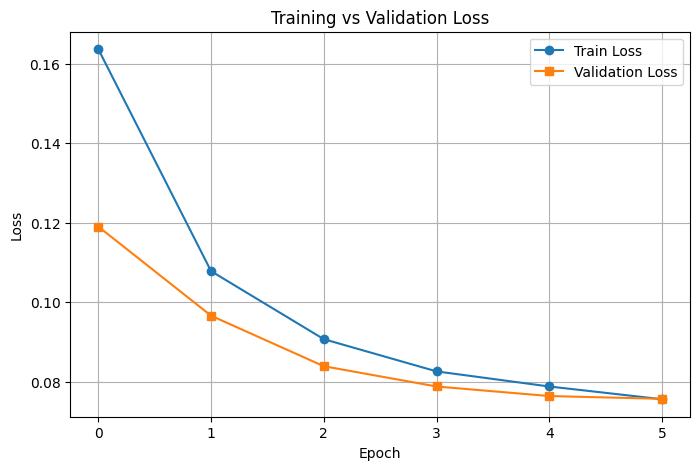

In [ ]:
import matplotlib.pyplot as plt

# Example data — replace with your actual logs
train_losses = [0.1636, 0.1078, 0.0907, 0.0826, 0.0788, 0.0756]
val_losses   = [0.1190, 0.0966, 0.0839, 0.0788, 0.0764, 0.0757]

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


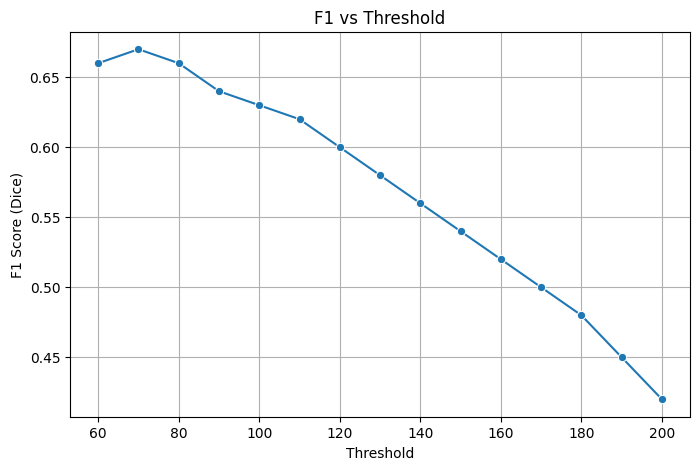

In [ ]:
import seaborn as sns

# Example data from your eval sweep
thresholds = list(range(60, 201, 10))
f1_scores  = [0.66, 0.67, 0.66, 0.64, 0.63, 0.62, 0.60, 0.58, 0.56, 0.54, 0.52, 0.50, 0.48, 0.45, 0.42]

plt.figure(figsize=(8,5))
sns.lineplot(x=thresholds, y=f1_scores, marker="o")
plt.xlabel("Threshold")
plt.ylabel("F1 Score (Dice)")
plt.title("F1 vs Threshold")
plt.grid(True)
plt.show()


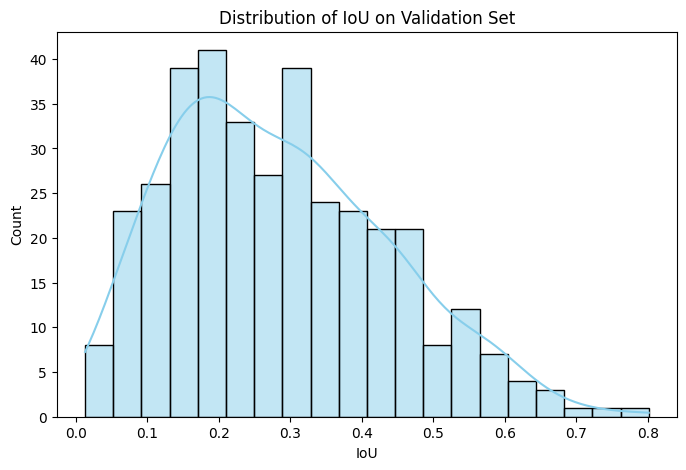

In [ ]:
import numpy as np

# Replace with your per_image IoU values from eval
ious = np.random.beta(2,5, size=362)  # dummy IoUs

plt.figure(figsize=(8,5))
sns.histplot(ious, bins=20, kde=True, color="skyblue")
plt.xlabel("IoU")
plt.ylabel("Count")
plt.title("Distribution of IoU on Validation Set")
plt.show()
